In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np # v1.25.2
import pandas as pd # v2.1.0
import random
from sklearn import metrics #sklearn v1.3.0
from sklearn.metrics import roc_auc_score, make_scorer, log_loss
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.utils import compute_class_weight
import xgboost as xgb # v2.0.0
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials # v0.2.7
from hyperopt.pyll import scope
from functools import partial
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Paths for data and results
path2data = 'D:\\__PROJECTS\\__AFbPP\\April2023\\affipred_models\\R1'
os.chdir(path2data)  # Change current working directory to the data path

# Split train and blind set
NUMBER = 3
path2res = f'D:\\__PROJECTS\\__AFbPP\\April2023\\affipred_models\\R1\\fold{NUMBER}\\'

# Define target and features
target = 'two_states'
features = ['GO_number', 'plddt_mean', 'kdHydrophobicity_DELTAmn', 'Volume_(A3)_n', 
            'plddt', 'ASA', 'b62', 'wt_psic', 'mt_psic', 'dpsic']

# Read training data
train = pd.read_csv(f"TRAIN{NUMBER}_CV0423.csv", sep=';')
X = train[features].to_numpy()  # Feature matrix
y = train[target].to_numpy()    # Target vector

In [3]:
evals = 200 # evaulation number of hyperopt
inner_f = 5 # inner fold of nested CV
outer_f = 10 # outer fold of nested CV
RND = 1 # Seed number

In [4]:
savename = "Fold"+ str(NUMBER) + "_" + str(evals) + "evals_nestcv_" + str(outer_f) + "_" + str(inner_f) + "_" + str(RND)

### Nested CV

In [5]:
# Hyperparameter space
space = {
    'objective': 'binary:logistic',
    'n_estimators': hp.choice('n_estimators', range(500, 2000)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'max_depth': hp.choice('max_depth', range(3, 10)),
    'min_child_weight': hp.loguniform('min_child_weight', -5, 5),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.uniform('gamma', 0.05, 10),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0.01,1)
}

In [6]:
# Create a list to store results of each evaluation step
evaluation_results = []

# Objective function for hyperopt optimization
def objective(params, X, y, cv):
    model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='auc')
    scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
    avg_score = np.average(scores)
    result = {'loss': -avg_score, 'status': STATUS_OK, 'params': params}
    evaluation_results.append(result)
    return result

# Nested cross-validation function
def nested_cv(X, y, cv_outer, cv_inner, space):
    outer_scores = []
    logloss_scores = []
    best_score = None

    for i, (train_idx, val_idx) in enumerate(cv_outer.split(X, y)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        inner_scores = []
        logloss = []

        for j, (train_idx_inner, val_idx_inner) in enumerate(cv_inner.split(X_train, y_train)):
            X_train_inner, y_train_inner = X_train[train_idx_inner], y_train[train_idx_inner]
            X_val_inner, y_val_inner = X_train[val_idx_inner], y_train[val_idx_inner]

            print(f"outer fold: {i}, inner fold: {j}")
            print(f"size of training, validation in outer: {len(X_train)}, {len(X_val)}")
            print(f"size of training, validation in inner: {len(X_train_inner)}, {len(X_val_inner)}")

            # Hyperparameter tuning with inner cross-validation
            obj_func = partial(objective, X=X_train_inner, y=y_train_inner, cv=cv_inner)
            result = fmin(fn=obj_func, space=space, algo=tpe.suggest, max_evals=evals,
                          rstate=np.random.default_rng(RND))

            # Fit model with best hyperparameters on entire training set
            params = {**space, **result}
            model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='auc')
            model.fit(X_train, y_train)

            # Evaluate model on outer validation set
            score = model.score(X_val, y_val)
            inner_scores.append(score)

            if best_score is None or score > best_score:
                best_score = score
                best_train_indices = train_idx
                best_test_indices = val_idx
                best_model = f"{i}_{j}"

            # Compute log loss on train and test sets
            y_train_pred = model.predict_proba(X_train)
            y_val_pred = model.predict_proba(X_val)
            train_loss = log_loss(y_train, y_train_pred)
            val_loss = log_loss(y_val, y_val_pred)
            logloss.append((train_loss, val_loss))

        logloss_scores.append(logloss)
        outer_scores.append(inner_scores)

    return params, outer_scores, logloss_scores, best_train_indices, best_test_indices, best_score, best_model

# Define outer and inner cross-validation folds
cv_outer = StratifiedKFold(n_splits=outer_f, shuffle=True, random_state=RND)
cv_inner = StratifiedKFold(n_splits=inner_f, shuffle=True, random_state=RND)

try:
    # Perform nested cross-validation
    best_params, scores, logloss, best_train_indices, best_test_indices, best_score, best_model = nested_cv(X, y, cv_outer, cv_inner, space)
    print("Best hyperparameters:", best_params)
    print("AUC from nested cross-validation:")
    for i, outer_fold_scores in enumerate(scores):
        print(f"Outer Fold {i+1}: {outer_fold_scores}")

except Exception as e:
    print("Error: ", e)

outer fold: 0, inner fold: 0
size of training, validation in outer: 38974, 4331
size of training, validation in inner: 31179, 7795
100%|█████████████████████████████████████████████| 200/200 [38:11<00:00, 11.46s/trial, best loss: -0.9563510366230862]
outer fold: 0, inner fold: 1
size of training, validation in outer: 38974, 4331
size of training, validation in inner: 31179, 7795
100%|█████████████████████████████████████████████| 200/200 [38:56<00:00, 11.68s/trial, best loss: -0.9564965165987551]
outer fold: 0, inner fold: 2
size of training, validation in outer: 38974, 4331
size of training, validation in inner: 31179, 7795
100%|█████████████████████████████████████████████| 200/200 [38:56<00:00, 11.68s/trial, best loss: -0.9568063886311767]
outer fold: 0, inner fold: 3
size of training, validation in outer: 38974, 4331
size of training, validation in inner: 31179, 7795
100%|█████████████████████████████████████████████| 200/200 [35:20<00:00, 10.60s/trial, best loss: -0.95790823955495

In [8]:
os.chdir(path2res)
res = pd.DataFrame(evaluation_results)
res.to_csv(str(savename)+"_XGB_hyperopt.csv",sep=";")

### Assessment of AFbPP on Unseen Test Set

In [9]:
best_params= {'objective': 'binary:logistic', 'n_estimators': np.int64(1105), 'learning_rate': np.float64(0.016721947327031198), 'max_depth': np.int64(5), 'min_child_weight': np.float64(0.017706147384722364), 'subsample': np.float64(0.9481078453478184), 'colsample_bytree': np.float64(0.6807975739102783), 'gamma': np.float64(0.07650614220692342), 'reg_alpha': np.float64(0.9037759867047068), 'reg_lambda': np.float64(0.537331493462159)}

In [10]:
# #Fit model on the entire training set
X = train[features]
y = train[target]
# Fit model on the entire training set
xgbs = xgb.XGBClassifier(**best_params, use_label_encoder=False)
xgbs.fit(X, y)

# Export the model and parameters
import pickle
model_path = os.path.join(path2data, f"affipred{NUMBER}_model.pkl")
params_path = os.path.join(path2data, f"affipred{NUMBER}_params.pkl")
with open(model_path, 'wb') as model_file:
    pickle.dump(xgbs, model_file)
with open(params_path, 'wb') as params_file:
    pickle.dump(best_params, params_file)

In [11]:
# Change directory back to the data path
os.chdir(path2data)
blind = pd.read_csv(f"BLIND{NUMBER}_CV0423.csv", sep=';')

# Predict unseen test set
X_blind = blind[features]
y_blind = blind[target]

# Identify known and unknown proteins
known_prot = list(set(train["uniprot"]))
unknown_prot = list(set(blind["uniprot"]))
common = [i for i in known_prot if i in unknown_prot]
known = [i for i in known_prot if i not in common]
unknown = [i for i in unknown_prot if i not in common]

print(f"\033[1mTraining set:\033[0m {len(train)} variants from {len(known)} proteins")
print(f"\033[1mHeld-out test set:\033[0m {len(blind)} variants from {len(unknown)} proteins")
print(f"\033[1mCommon proteins in train and blind sets:\033[0m {len(common)}")

# Make predictions on the blind test set
y_pred = xgbs.predict(X_blind)
y_prob = xgbs.predict_proba(X_blind)[:,1]

# Save predictions to blind DataFrame
blind[f"Affipred{NUMBER}"] = y_pred
blind[f"Affipred_prob{NUMBER}"] = y_prob

# Define evaluation functions
from sklearn import metrics

def evaluation_analysis(true_label, predicted, predictor, dataset):
    eval_results = {
        "dataset": dataset,
        "predictor": predictor,
        "size": len(true_label),
        "f1": metrics.f1_score(true_label, predicted, average='binary'),
        "precision": metrics.precision_score(true_label, predicted),
        "recall": metrics.recall_score(true_label, predicted),
        "accuracy": metrics.accuracy_score(true_label, predicted),
        "matthews_corr": metrics.matthews_corrcoef(true_label, predicted),
        "confusion_matrix": metrics.confusion_matrix(true_label, predicted)
    }
    return eval_results

def evaluation_analysis2(true_label, predicted_score, predictor, dataset):
    eval_results = {
        "dataset": dataset,
        "predictor": predictor,
        "size": len(true_label),
        "auc": metrics.roc_auc_score(true_label, predicted_score),
        "log_loss": metrics.log_loss(true_label, predicted_score)
    }
    return eval_results

# Uncomment to save predictions to CSV
blind.to_csv(f"pred_BLIND{NUMBER}_CV0423_affi_r1.csv", sep=';')

Training set: 43305 variants from 3566 proteins
Held-out test set: 19688 variants from 1783 proteins
Common proteins in train and blind sets: 0


In [13]:
# Performance assessment
pred_list = ['SIFT_converted_rankscore', 'SIFT4G_converted_rankscore','Polyphen2_HDIV_rankscore', 'Polyphen2_HVAR_rankscore', 
           'LRT_converted_rankscore', 'MutationTaster_converted_rankscore', 'MutationAssessor_rankscore', 'FATHMM_converted_rankscore', 
           'PROVEAN_converted_rankscore', 'VEST4_rankscore','MetaSVM_rankscore','MetaLR_rankscore', 'MetaRNN_rankscore', 
           'M-CAP_rankscore','REVEL_rankscore','MutPred_rankscore', 'MVP_rankscore','MPC_rankscore', 'PrimateAI_rankscore', 
            'DEOGEN2_rankscore','BayesDel_addAF_rankscore','BayesDel_noAF_rankscore', 'ClinPred_rankscore', 'LIST-S2_rankscore', 
           'CADD_raw_rankscore', 'DANN_rankscore', 'fathmm-MKL_coding_rankscore','fathmm-XF_coding_rankscore', 'Eigen-raw_coding_rankscore', 
            'Eigen-PC-raw_coding_rankscore', 'GenoCanyon_rankscore', 'integrated_fitCons_rankscore', 'GERP++_RS_rankscore', 
            'phyloP100way_vertebrate_rankscore', 'phyloP30way_mammalian_rankscore','phastCons100way_vertebrate_rankscore', 
            'phastCons30way_mammalian_rankscore', 'SiPhy_29way_logOdds_rankscore','EVmutation_score', 'PolyPhen-2_score',
             'Affipred_prob3','AlphScore', 'glm_AlphCadd', 'glm_AlphRevel', 'glm_RevelCadd', 'glm_AlphRevelCadd', 'glm_AlphDeogen', 
             'glm_CaddDeogen', 'glm_DeogenRevel', 'glm_AlphDeogenRevel', 'glm_AlphCaddDeogen', 'glm_CaddDeogenRevel','AM_pathogenicity','two_states']

#########################################
df1 = blind
df2 = df1.loc[df1["training_info"]=="new"]

### Evaluate on all of the unseen test set
df = df1[pred_list]
perf = []
for p in pred_list:
    dx = df.loc[~df[p].isna()]
    dx[p] =pd.to_numeric(dx[p],downcast="integer")
    d1 = pd.DataFrame([evaluation_analysis2(dx["two_states"],dx[p], p,"all")])
    d2 = pd.DataFrame([evaluation_analysis2(dx["two_states"],dx['Affipred_prob3'], "Affipred",p)])
    d3 = pd.concat([d1,d2])
    perf.append(d3)

dfx = pd.concat(perf)
dfx = dfx.loc[dfx["predictor"]!="two_states"]
dfx1 = dfx

#####################################################

pred_list2=['two_states','Affipred_prob3','rhapsody_prob.']
df = df2[pred_list2]

dx = df.loc[~df["rhapsody_prob."].isna()]
d1 = pd.DataFrame([evaluation_analysis2(dx["two_states"],dx["Affipred_prob3"], "Affipred","rhapsody_prob.")])
d2 = pd.DataFrame([evaluation_analysis2(dx["two_states"],dx["rhapsody_prob."], "rhapsody_prob.","all")])

dfx = pd.concat([d1,d2])
dfx2 = pd.concat([dfx1,dfx])
pd.set_option('display.max_rows', None)

display(dfx2)

os.chdir(path2res)
dfx2.to_csv(str(savename)+"_unseen_auc_logloss.csv", sep=";")

,dataset,predictor,size,auc,log_loss
0,all,SIFT_converted_rankscore,19191,0.859929,0.498213
0,SIFT_converted_rankscore,Affipred,19191,0.930257,0.329728
0,all,SIFT4G_converted_rankscore,18919,0.857454,0.506071
0,SIFT4G_converted_rankscore,Affipred,18919,0.930695,0.329310
0,all,Polyphen2_HDIV_rankscore,19002,0.846427,0.516168
0,Polyphen2_HDIV_rankscore,Affipred,19002,0.928793,0.334593
0,all,Polyphen2_HVAR_rankscore,19002,0.873384,0.477571
0,Polyphen2_HVAR_rankscore,Affipred,19002,0.928793,0.334593
0,all,LRT_converted_rankscore,18589,0.835360,0.515015
0,LRT_converted_rankscore,Affipred,18589,0.929198,0.334632


In [16]:
pred_list = ['SIFT_pred', 'SIFT4G_pred', 'Polyphen2_HDIV_pred', 'Polyphen2_HVAR_pred', 'LRT_pred', 'MutationTaster_pred', 
             'MutationAssessor_pred', 'FATHMM_pred', 'PROVEAN_pred', 'MetaSVM_pred', 'MetaLR_pred', 'MetaRNN_pred', 'M-CAP_pred', 
             'PrimateAI_pred', 'DEOGEN2_pred', 'BayesDel_addAF_pred', 'BayesDel_noAF_pred', 'ClinPred_pred', 'LIST-S2_pred', 
             'fathmm-MKL_coding_pred', 'fathmm-XF_coding_pred', 'EVmutation_two_states', 'PolyPhen-2_two_states','am_class', 'am_class2', 'two_states', 
             'Affipred3']

#####################################################
df1 = blind
df2 = df1.loc[df1["training_info"]=="new"]

### Evaluate on all of the unseen test set
df = df1[pred_list]
perf = []
for p in pred_list:
    dx = df.loc[~df[p].isna()]
    dx[p] =pd.to_numeric(dx[p],downcast="integer")

    if p is "am_class":
        dx = dx.loc[dx["am_class"]!=2]
        d1 = pd.DataFrame([evaluation_analysis(dx["two_states"],dx[p], p,"all")])
        d2 = pd.DataFrame([evaluation_analysis(dx["two_states"],dx['Affipred3'], "Affipred",p)])
        d3 = pd.concat([d1,d2])
        perf.append(d3)
    else:
        d1 = pd.DataFrame([evaluation_analysis(dx["two_states"],dx[p], p,"all")])
        d2 = pd.DataFrame([evaluation_analysis(dx["two_states"],dx['Affipred3'], "Affipred",p)])
        d3 = pd.concat([d1,d2])
        perf.append(d3)

dfx = pd.concat(perf)
dfx = dfx.loc[dfx["predictor"]!="two_states"]
dfx1 = dfx

#####################################################

pred_list2=['two_states','Affipred3','rhapsody_two_states']
df = df2[pred_list2]

dx = df.loc[~df["rhapsody_two_states"].isna()]
d1 = pd.DataFrame([evaluation_analysis(dx["two_states"],dx["Affipred3"], "Affipred","rhapsody_two_states")])
d2 = pd.DataFrame([evaluation_analysis(dx["two_states"],dx["rhapsody_two_states"], "rhapsody_two_states","all")])

dfx = pd.concat([d1,d2])

dfx2 = pd.concat([dfx1,dfx])
display(dfx2)

os.chdir(path2res)
dfx2.to_csv(str(savename)+"_unseen_f1_mcc_acc.csv", sep=";")

,dataset,predictor,size,f1,precision,recall,accuracy,matthews_corr,confusion_matrix
0,all,SIFT_pred,19191,0.737935,0.625802,0.899027,0.743630,0.534197,"[[7344, 4142], [778, 6927]]"
0,SIFT_pred,Affipred,19191,0.824524,0.839725,0.809864,0.861602,0.710647,"[[10295, 1191], [1465, 6240]]"
0,all,SIFT4G_pred,18919,0.746854,0.670240,0.843243,0.769280,0.551984,"[[8115, 3168], [1197, 6439]]"
0,SIFT4G_pred,Affipred,18919,0.825282,0.842450,0.808800,0.861779,0.711428,"[[10128, 1155], [1460, 6176]]"
0,all,Polyphen2_HDIV_pred,19002,0.728336,0.607386,0.909432,0.723661,0.509107,"[[6712, 4550], [701, 7039]]"
0,Polyphen2_HDIV_pred,Affipred,19002,0.823008,0.842789,0.804134,0.859120,0.706645,"[[10101, 1161], [1516, 6224]]"
0,all,Polyphen2_HVAR_pred,19002,0.761325,0.675678,0.871835,0.777339,0.574860,"[[8023, 3239], [992, 6748]]"
0,Polyphen2_HVAR_pred,Affipred,19002,0.823008,0.842789,0.804134,0.859120,0.706645,"[[10101, 1161], [1516, 6224]]"
0,all,LRT_pred,17606,0.760227,0.651628,0.912261,0.761956,0.566783,"[[6771, 3552], [639, 6644]]"
0,LRT_pred,Affipred,17606,0.824715,0.840896,0.809145,0.857719,0.705423,"[[9208, 1115], [1390, 5893]]"


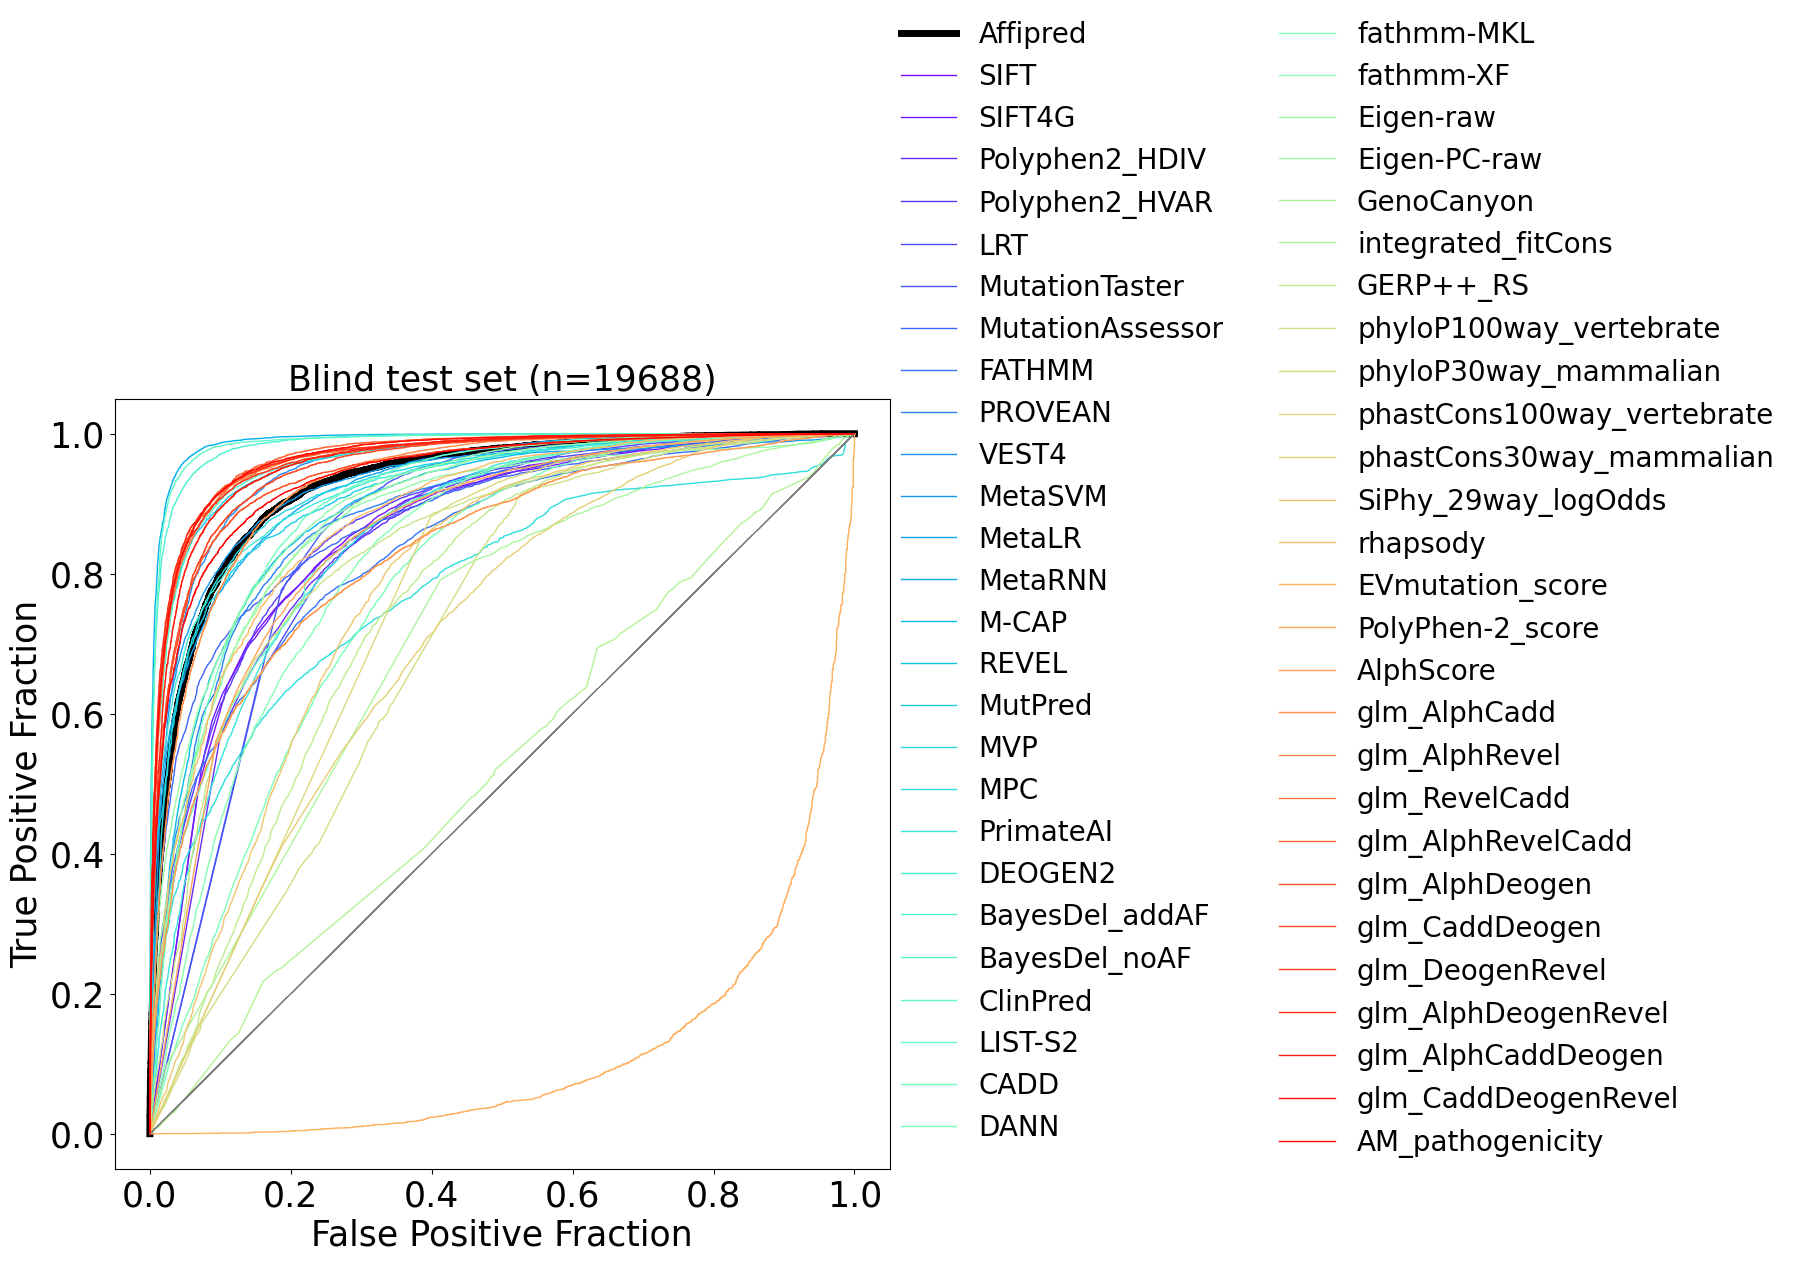

In [21]:
df1 = blind
df1['EVmutation_score']=1-df1['EVmutation_score']
predscores = ['SIFT_converted_rankscore', 'SIFT4G_converted_rankscore','Polyphen2_HDIV_rankscore', 'Polyphen2_HVAR_rankscore', 
           'LRT_converted_rankscore', 'MutationTaster_converted_rankscore', 'MutationAssessor_rankscore', 'FATHMM_converted_rankscore', 
           'PROVEAN_converted_rankscore', 'VEST4_rankscore','MetaSVM_rankscore','MetaLR_rankscore', 'MetaRNN_rankscore', 
           'M-CAP_rankscore','REVEL_rankscore','MutPred_rankscore', 'MVP_rankscore','MPC_rankscore', 'PrimateAI_rankscore', 
            'DEOGEN2_rankscore','BayesDel_addAF_rankscore','BayesDel_noAF_rankscore', 'ClinPred_rankscore', 'LIST-S2_rankscore', 
           'CADD_raw_rankscore', 'DANN_rankscore', 'fathmm-MKL_coding_rankscore','fathmm-XF_coding_rankscore', 'Eigen-raw_coding_rankscore', 
            'Eigen-PC-raw_coding_rankscore', 'GenoCanyon_rankscore', 'integrated_fitCons_rankscore', 'GERP++_RS_rankscore', 
            'phyloP100way_vertebrate_rankscore', 'phyloP30way_mammalian_rankscore','phastCons100way_vertebrate_rankscore', 
            'phastCons30way_mammalian_rankscore', 'SiPhy_29way_logOdds_rankscore','rhapsody_prob.', 'EVmutation_score', 'PolyPhen-2_score','AlphScore', 'glm_AlphCadd', 'glm_AlphRevel', 'glm_RevelCadd', 'glm_AlphRevelCadd', 'glm_AlphDeogen', 
             'glm_CaddDeogen', 'glm_DeogenRevel', 'glm_AlphDeogenRevel', 'glm_AlphCaddDeogen', 'glm_CaddDeogenRevel','AM_pathogenicity']


ls = ["two_states","Affipred_prob3"]
predscores = ls + predscores
# print(predscores)
# predscores = [i for i in predscores if "_score" not in i]
# df1 = blind
df2 = df1.loc[df1["training_info"]=="new"]

### Evaluate on all of the unseen test set
df = df1[predscores]
predscores = [i for i in predscores if "two_states" not in i ]

prednames = []
for p in predscores:
    head, sep, tail = p.partition('_r')
    head, sep, tail = head.partition('_co')
    head, sep, tail = head.partition('_prob')
    prednames.append(head)

colors = []
for i in range(len(predscores)-1):
    color = plt.cm.seismic(np.linspace(0, 1, len(predscores)-1))
    colors.append(color)

rocvals = []
for i, p in enumerate(predscores):
    # print(p)
    color = plt.cm.rainbow(np.linspace(0, 1, len(predscores)))

    dx = df.loc[~df[p].isna()]
    fpr, tpr, thres = metrics.roc_curve(dx["two_states"], dx[p])
    dr = {"name":p,"fpr":fpr,"tpr":tpr,"scores":thres}
    dr = pd.DataFrame(dr)

    if prednames[i] == "Affipred":
        plt.figure(figsize=(10,10))
        plt.plot(fpr,tpr,label=prednames[i],color="black",linewidth=5)
    else:

        plt.plot(fpr,tpr,label=prednames[i],color=color[i],linewidth=1,linestyle="-")
        plt.plot([0,0.5,1],[0,0.5,1],color ="grey",linestyle="-",linewidth=0.5)
        plt.ylabel('True Positive Fraction',fontsize=25)
        plt.xlabel('False Positive Fraction',fontsize=25)
        plt.tick_params(axis='both', which='both', labelsize=25)
        plt.legend(loc =(1,0),ncol= 2,frameon=False,fontsize=20)
        plt.title("Blind test set (n="+str(len(df1))+")",fontsize=25,x=0.5, y=1.0)
os.chdir(path2res)
plt.savefig(str(savename) +'_ROCblindtest.png', facecolor='w', bbox_inches='tight', pad_inches=0.01)

plt.show()

### Proteome Prediction

In [20]:
aa_list = ["A","C","D","E","F","G","H","I","K","L","M","N","P","Q","R","S","T","V","W","Y"]
for aa in aa_list:
    os.chdir('D:\\__PROJECTS\\__AFbPP\\April2023\\affipred_models\\R1\\DB\\')
    df = pd.read_csv("DB_10feat_AFbPP_fold12_evals"+str(evals)+"_mutant_"+str(aa)+".csv",sep=";")
    X = df[features]
    y_pred = xgbs.predict(X)
    y_prob = xgbs.predict_proba(X)[:,1]
    df["Affipred"+str(NUMBER)] = y_pred
    df["Affipred_prob"+str(NUMBER)] = y_prob

    df = df.loc[df["native"]!=df["mutant"]]
    # Calculate the mean and standard deviation for each row (across the three columns)
    df['Affipred_prob_mean'] = df[['Affipred_prob1', 'Affipred_prob2', 'Affipred_prob3']].mean(axis=1)
    df['Affipred_prob_std'] = df[['Affipred_prob1', 'Affipred_prob2', 'Affipred_prob3']].std(axis=1)
    
    df.to_csv("DB_10feat_AFbPP_fold12"+str(NUMBER)+"_evals"+str(evals)+"_mutant_"+str(aa)+".csv",sep=";")
    print(aa)
    os.remove("DB_10feat_AFbPP_fold12_evals"+str(evals)+"_mutant_"+str(aa)+".csv")

A
C
D
E
F
G
H
I
K
L
M
N
P
Q
R
S
T
V
W
Y


In [ ]:
# os.chdir('D:\\__PROJECTS\\__AFbPP\\April2023\\affipred_models\\R1\\DB\\')
# aa_list = ["A","C","D","E","F","G","H","I","K","L","M","N","P","Q","R","S","T","V","W","Y"]

# for aa in aa_list:
#     df = pd.read_csv("DB_10feat_AFbPP_fold123_evals"+str(evals)+"_mutant_"+str(aa)+".csv",sep=";")
#     print(aa,len(df))
# #     print(list(df))
#     df = df.loc[df["native"]!=df["mutant"]]

#     # Calculate the mean and standard deviation for each row (across the three columns)
#     df['Affipred_prob_mean'] = df[['Affipred_prob1', 'Affipred_prob2', 'Affipred_prob3']].mean(axis=1)
#     df['Affipred_prob_std'] = df[['Affipred_prob1', 'Affipred_prob2', 'Affipred_prob3']].std(axis=1)

#     # Show the resulting dataframe
#     df[['Affipred_prob1', 'Affipred_prob2', 'Affipred_prob3', 'Affipred_mean', 'Affipred_std']]
#     df["Affipred_sum"] = df["Affipred1"]+df["Affipred2"]+df["Affipred3"]
#     print(set(df["Affipred_sum"]))
#     df0 = df.loc[df["Affipred_sum"]==0]
#     df1 = df.loc[df["Affipred_sum"]==1]
#     df2 = df.loc[df["Affipred_sum"]==2]
#     df3 = df.loc[df["Affipred_sum"]==3]
#     print(len(df0),len(df1),len(df2),len(df3))